In [54]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

import warnings
warnings.filterwarnings("ignore")

In [55]:
path = "../input/pickle/"

train = pd.read_pickle(path + "train.zip")
train_x = train.drop(["y"], axis=1)
train_y = train["y"]
test_x = pd.read_pickle(path + "test.zip")

In [56]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543133 entries, 0 to 543132
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               543133 non-null  int64  
 1   month              543133 non-null  int64  
 2   shopID             543133 non-null  int64  
 3   itemID             543133 non-null  int64  
 4   item_categoryID    543133 non-null  int64  
 5   item_category_big  543133 non-null  int64  
 6   item_price         543133 non-null  int64  
 7   release_time       543133 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 37.3 MB


In [57]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3060 entries, 0 to 3059
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   itemID             3060 non-null   int64  
 1   shopID             3060 non-null   int64  
 2   item_categoryID    3060 non-null   int64  
 3   item_category_big  3060 non-null   int64  
 4   month              3060 non-null   int64  
 5   year               3060 non-null   int64  
 6   item_price         3060 non-null   float64
 7   release_time       3060 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 215.2 KB


In [59]:
test_x

,itemID,shopID,item_categoryID,item_category_big,month,year,item_price,release_time
0,1000001,0,100,5,12,2019,250.0,713
1,1000001,1,100,5,12,2019,420.0,713
2,1000001,2,100,5,12,2019,250.0,713
3,1000001,3,100,5,12,2019,250.0,713
4,1000001,4,100,5,12,2019,250.0,713
...,...,...,...,...,...,...,...,...
3055,3500001,13,350,6,12,2019,420.0,703
3056,3500001,14,350,6,12,2019,420.0,703
3057,3500001,15,350,6,12,2019,200.0,703
3058,3500001,16,350,6,12,2019,420.0,703


In [60]:
train_x.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            543123, 543124, 543125, 543126, 543127, 543128, 543129, 543130,
            543131, 543132],
           dtype='int64', length=543133)

In [61]:
years = [2018] * 6 + [2019] * 9
months = list(range(7, 13)) + list(range(1, 10))

In [62]:
month_list = list(range(1, 7))
year_list = [2017] + [2018]

scores = []

# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", 
              "metric" : "rmse", 
              "n_estimators":20000, 
              "early_stopping_rounds":200,
              "num_leaves" : 31, 
              "learning_rate" : 0.01, 
              "bagging_fraction" : 0.7,
              "bagging_seed" : 0, 
              "num_threads" : 4,
              "colsample_bytree" : 0.7,
              'max_depth': 5
             }
    
    lgtrain = lgb.Dataset(tr_x, tr_y)
    lgval = lgb.Dataset(va_x, va_y)
    model = lgb.train(params, lgtrain, 
                      valid_sets=[lgtrain, lgval], 
                      verbose_eval=1000)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

for year, month in zip(years, months):
    if year == 2019 and len(year_list) == 2:
        year_list = year_list.append(year)
    
    month_list.append(month)
    
    if month == 12:
        year += 1
        month = 1
    
    tr_x = train_x[(train_x["year"].isin(year_list))&(train_x["month"].isin(month_list))]
    va_x = train_x[(train_x["year"] == year)&(train_x["month"] == month)]
    tr_y, va_y = train_y.iloc[tr_x.index], train_y.iloc[va_x.index]
    
    # Training the model
    pred_test, model = run_lgb(tr_x, tr_y, va_x, va_y, test_x)
    
    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x)
    score = np.sqrt(mean_squared_error(va_y, va_pred))
    
    scores.append(score)

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 3.4713	valid_1's rmse: 2.96024
[2000]	training's rmse: 3.19759	valid_1's rmse: 2.79128
[3000]	training's rmse: 3.05048	valid_1's rmse: 2.70889
[4000]	training's rmse: 2.95314	valid_1's rmse: 2.62683
[5000]	training's rmse: 2.88038	valid_1's rmse: 2.57244
[6000]	training's rmse: 2.83457	valid_1's rmse: 2.53868
[7000]	training's rmse: 2.8047	valid_1's rmse: 2.51209
[8000]	training's rmse: 2.77128	valid_1's rmse: 2.48282
[9000]	training's rmse: 2.74302	valid_1's rmse: 2.45948
[10000]	training's rmse: 2.72148	valid_1's rmse: 2.43758
[11000]	training's rmse: 2.69779	valid_1's rmse: 2.42287
[12000]	training's rmse: 2.674	valid_1's rmse: 2.39391
[13000]	training's rmse: 2.65239	valid_1's rmse: 2.37308
[14000]	training's rmse: 2.62442	valid_1's rmse: 2.34946
[15000]	training's rmse: 2.60589	valid_1's rmse: 2.33407
[16000]	training's rmse: 2.58958	valid_1's rmse: 2.32075
[17000]	training's rmse: 2.57331	valid_

In [67]:
scores

[2.2576540949341473,
 2.2041040992422736,
 2.5328788580454633,
 3.3537457073392254,
 2.8160946182591875,
 3.2042056876587353,
 3.2042056876587353,
 2.8348026555737555,
 3.507482884232313,
 2.6001249837885023,
 2.681361545922712,
 2.9163600432646684,
 2.3917148410545863,
 2.67681609430529,
 2.6066843612010673]

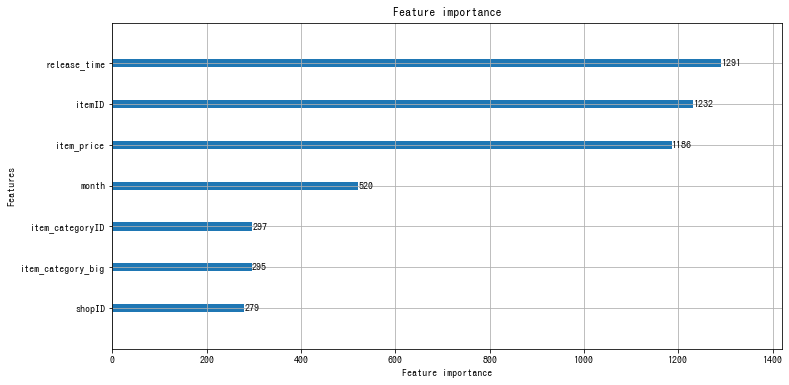

In [69]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

In [63]:
# 予測
pred = model.predict(test_x)

In [65]:
path = "../submission/"

submission = pd.read_csv(path + "sample_submission.csv", header=None)

submission.iloc[:,[1]] = pred
submission.head()

,0,1
0,0,1.598766
1,1,1.602905
2,2,1.598766
3,3,1.588539
4,4,1.588539


In [66]:
submission.to_csv(path + "submission.csv", index=False, header=None)